# Задача

- провести базовую аналитику по имеющимся данным

- обучить модель по тексту сообщения определять, является ли ее содержимое СПАМом

- Целевая метрика: ROC-AUC score

- провести скоринг лучшей моделью тестовых данных, результат записать в CSV файл в виде таблицы с колонками score и text

# Аналитика


In [192]:
import pandas as pd

df = pd.read_csv("/content/train_spam.csv")

# проверяем, что тренировочный датасет не содержит пустые значения
assert df.isnull().values.any() == False

# для удобства заменим колонку text_type на колонку labelсо значениями 0 и 1
df['label'] = df.apply(lambda row: 1 if row.text_type == 'spam' else 0, axis=1)
df = df.drop(columns='text_type')
df

,text,label
0,make sure alex knows his birthday is over in f...,0
1,a resume for john lavorato thanks vince i will...,0
2,plzz visit my website moviesgodml to get all m...,1
3,urgent your mobile number has been awarded wit...,1
4,overview of hr associates analyst project per ...,0
...,...,...
16273,if you are interested in binary options tradin...,1
16274,dirty pictureblyk on aircel thanks you for bei...,1
16275,or you could do this g on mon 1635465 sep 1635...,0
16276,insta reels par 80 गंद bhara pada hai 👀 kuch b...,0


In [193]:
# посмотрим, как распределены данные в датасете
df['label'].value_counts()

label
0    11469
1     4809
Name: count, dtype: int64

Видим, что в датасете примерно в 2 раза больше отрицательных примеров, чем положительных. Сформируем отдельную валидационную выборку для сравнения разных алгоритмов между собой и выбора оптимального по целевой метрике. Позже после выбора алгоритма можно будет обучит его на всех данных, включив в датасет валидационную выборку.

In [194]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df['label']
)

# Обучение моделей

## 1. Наивный байес
Один из стандартных методов решения задачи классификации спама: https://ru.wikipedia.org/wiki/%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D1%81%D0%BF%D0%B0%D0%BC%D0%B0

Плюсы этого подхода:

1. Легко интерпретировать результаты классификации, так как весь подход основан о статистических данных о словах (какие-то слова встречаются в спам письмах гораздо чаще, чем в не-спаме)

2. Для обучения не нужны большие вычислительные мощности и ГПУ.

Недостатки: наивный байесовский классификатор никак не учитывает семантические связи слов текста письма, потому что основан на гипотезе о независимости отдельных токенов.

Реализация алгоритма и код для отрисовки графиков взяты из выполненного мною ДЗ курса по NLP от ШАДа (https://github.com/yandexdataschool/nlp_course)

In [195]:
import numpy as np

class BinaryNaiveBayes:
    delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=k) for k = 0,1
        self.p_y = np.array([
            np.count_nonzero(y == 0) / len(y),
            np.count_nonzero(y == 1) / len(y)
        ])

        # count occurences of each word in texts with label 1 and label 0 separately
        word_counts_positive = X[y == 1].sum(axis=0)
        word_counts_negative = X[y == 0].sum(axis=0)
        # ^-- both must be vectors of shape [vocab_size].

        # finally, lets use those counts to estimate p(x | y = k) for k = 0, 1

        self.p_x_given_positive = (self.delta + word_counts_positive) / np.sum(self.delta + word_counts_positive)
        self.p_x_given_negative = (self.delta + word_counts_negative) / np.sum(self.delta + word_counts_negative)
        # both must be of shape [vocab_size]; and don't forget to add self.delta!

        return self

    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-product with X
        score_negative = np.log(self.p_y[0]) + X @ np.log(self.p_x_given_negative)
        score_positive = np.log(self.p_y[1]) + X @ np.log(self.p_x_given_positive)

        # you can compute total p(x | y=k) with a dot product
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [196]:
# сначала переведем все письма в нижний регистр и токенизируем тексты на отдельные слова и знаки пунктуации, разделенные пробелами
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

texts_train = [preprocess(text) for text in X_train]
texts_val = [preprocess(text) for text in X_val]

In [197]:
from collections import Counter

token_counts = Counter()

# посчитаем как часто каждый токен встречается во всех сообщениях тренировочного датасета
for text in texts_train:
  for token in text.split():
    token_counts[token] += 1

#отсортируем токены по убыванию их частотности
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

#уменьшим размер словаря, убрав из него токены с частотой меньше 10
sorted_tokens = [(token, frequency) for (token, frequency) in sorted_tokens if frequency >= 10]

bow_vocabulary = [token for (token, _) in sorted_tokens]
print(f"размер словаря: {len(bow_vocabulary)}")

token_to_id = {}
for ind, token in enumerate(bow_vocabulary):
  token_to_id[token] = ind

def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    result = [0] * len(bow_vocabulary)

    for token in text.split():
      if token in token_to_id:
        result[token_to_id[token]] += 1

    return np.array(result, 'float32')

X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_val_bow = np.stack(list(map(text_to_bow, texts_val)))

размер словаря: 6100


In [198]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

Model accuracy: 0.911
Model f1 score: 0.862


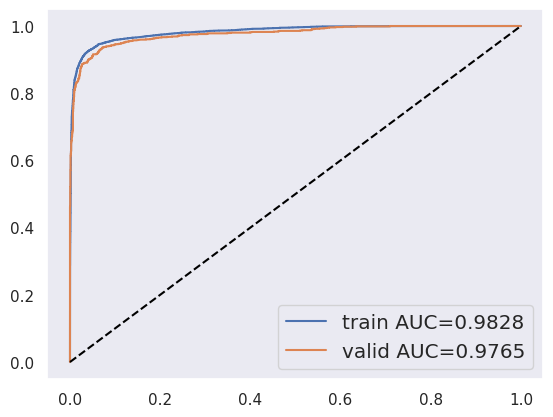

In [199]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('valid', X_val_bow, y_val, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_val_bow) == y_val)
test_f1_score = f1_score(y_val, naive_model.predict(X_val_bow))
print(f"Model accuracy: {test_accuracy:.3f}")
print(f"Model f1 score: {test_f1_score:.3f}")

Видим, что самый простой наивный байесовский подход уже дает достаточно хорошее значение метрики ROC-AUC score.

# 2. fasttext эмбеддинги + логистическая регрессия

Другой популярный подход для решения подобных задач это сначала получить векторные представления (эмбеддинги) текстов, затем применить к ним какой-либо алгоритм классификации (например, логистическую регрессию).

Есть 2 основных способа получения эмбеддингов текста:

1. берем предобученные эмбеддинги (word2vec, fasttext, glove и тд), каждому слову предложения сопоставляем эмбеддинг (если слова нет в словаре эмбеддингов, просто пропускаем его), суммируем эмбеддинги, чтобы получить векторное представление текста. Можно также попробовать усреднить эмбеддинги токенов или складывать их с какими-то весами, коррелирующими с важностью отдельных токенов (например, умножать tf-idf метрику, посчитанную на тренировочном датасете)

2. используем какую-нибудь нейросетевую модель sentence-encoder, которая будет давать на выходе эмбеддинг всего текста. преимущество такого подхода над предыдущим это то, что такие модели могут учитывать семантические связи между отдельными словами и их порядок, что почти всегда существенно влияет на смысл текста. Можно также попробовать пофайнтюнить LLM (например, BERT), потому что таким образом мы тоже будем получать эмбеддинг для всего текста с помощью большой языковой модели, а в роли классификаторы выступит последний линейный слой размера (размерность_эмбеддинга, 2)

Для простоты я решила попробовать первый способ, потому что в предыдущем эксперименте bag-of-words подход уже дал приемлимый результат

In [182]:
import gensim.downloader

# Используем предобученные эмбеддинги fasttext из gensim. Если есть большое количество данных, можно обучить на них свой корпус эмбеддингов, специфичный для домена
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [200]:
def vectorize_sum(text):
    embedding_dim = embeddings.vector_size
    features = np.zeros([embedding_dim], dtype='float32')

    for token in text.split():
      if token in embeddings:
        features += embeddings[token]

    return features

X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_val_wv = np.stack([vectorize_sum(text) for text in texts_val])

In [201]:
from sklearn.linear_model import LogisticRegression

wv_model = LogisticRegression(max_iter=1000).fit(X_train_wv, y_train)

Model accuracy: 0.923
Model f1 score: 0.862


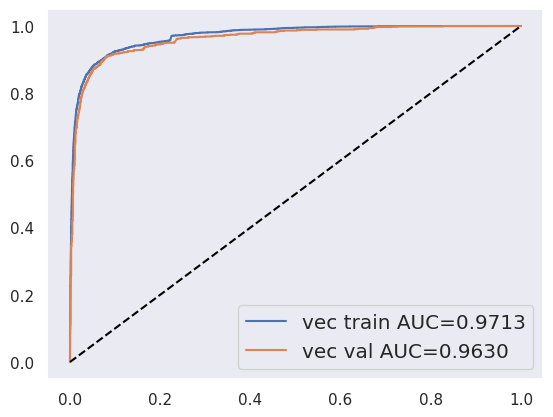

In [202]:
for name, X, y, model in [
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec val', X_val_wv, y_val, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(wv_model.predict(X_val_wv) == y_val)
test_f1_score = f1_score(y_val, wv_model.predict(X_val_wv))
print(f"Model accuracy: {test_accuracy:.3f}")
print(f"Model f1 score: {test_f1_score:.3f}")

# 3. Выбор модели с помощью кросс-валидации

Так как метрики на отдельной валидационной выборке получились примерно одинаковыми, проведем кросс-валидацию, чтобы из двух моделей выбрать лучшую

In [203]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
X = df['text']
y = df['label']

bayes_auc = []
logreg_auc = []


for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
  print(i)
  X_train = X[train_idx]
  y_train = y[train_idx]
  X_test = X[test_idx]
  y_test = y[test_idx]

  texts_train = [preprocess(text) for text in X_train]
  texts_test = [preprocess(text) for text in X_test]

  # Naive Bayes
  token_counts = Counter()

  for text in texts_train:
    for token in text.split():
      token_counts[token] += 1

  sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
  sorted_tokens = [(token, frequency) for (token, frequency) in sorted_tokens if frequency >= 10]
  bow_vocabulary = [token for (token, _) in sorted_tokens]

  token_to_id = {}
  for ind, token in enumerate(bow_vocabulary):
    token_to_id[token] = ind

  def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    result = [0] * len(bow_vocabulary)

    for token in text.split():
      if token in token_to_id:
        result[token_to_id[token]] += 1

    return np.array(result, 'float32')

  X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
  X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

  model = BinaryNaiveBayes().fit(X_train_bow, y_train)
  proba = model.predict_scores(X_test_bow)[:, 1] - model.predict_scores(X_test_bow)[:, 0]
  auc = roc_auc_score(y_test, proba)
  print(f"bayes ROC-AUC score: {auc}")
  bayes_auc.append(auc)


  # Logistic Regression
  X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
  X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

  model = LogisticRegression(max_iter=1000).fit(X_train_wv, y_train)
  proba = model.predict_proba(X_test_wv)[:, 1]
  auc = roc_auc_score(y_test, proba)
  print(f"logreg ROC-AUC score: {auc}")
  logreg_auc.append(auc)

0
bayes ROC-AUC score: 0.9771282582965234
logreg ROC-AUC score: 0.9623393848546421
1
bayes ROC-AUC score: 0.9723215855517511
logreg ROC-AUC score: 0.9592958762531562
2
bayes ROC-AUC score: 0.9734528472540678
logreg ROC-AUC score: 0.9584455607777317
3
bayes ROC-AUC score: 0.9739443800821399
logreg ROC-AUC score: 0.9611627672787083
4
bayes ROC-AUC score: 0.9757711937171161
logreg ROC-AUC score: 0.9585103990904253


In [205]:
from numpy import mean

print(f"Mean bayes  ROC-AUC score: {mean(bayes_auc)}")
print(f"Mean logreg ROC-AUC score: {mean(logreg_auc)}")

Mean bayes  ROC-AUC score: 0.9745236529803197
Mean logreg ROC-AUC score: 0.9599507976509327


Видим, что целевая метрика лучше у первого алгоритма, поэтому обучим эту модель на всех тренировочных данных

In [235]:
X = df['text']
y = df['label']

texts_train = [preprocess(text) for text in X]

token_counts = Counter()

for text in texts_train:
  for token in text.split():
    token_counts[token] += 1

sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
sorted_tokens = [(token, frequency) for (token, frequency) in sorted_tokens if frequency >= 10]
bow_vocabulary = [token for (token, _) in sorted_tokens]

token_to_id = {}
for ind, token in enumerate(bow_vocabulary):
  token_to_id[token] = ind

def text_to_bow(text):
  """ convert text string to an array of token counts. Use bow_vocabulary. """
  result = [0] * len(bow_vocabulary)

  for token in text.split():
    if token in token_to_id:
      result[token_to_id[token]] += 1

  return np.array(result, 'float32')

X_train = np.stack(list(map(text_to_bow, texts_train)))

best_model = BinaryNaiveBayes().fit(X_train, y)

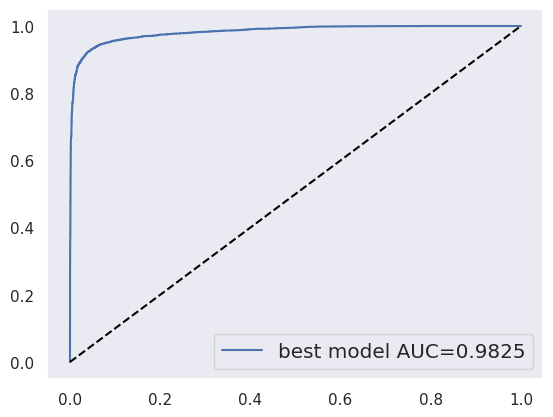

In [236]:
# на всякий случай, убедимся, что модель показывает ROC-AUC score на тренировочных данных близкий к 1.0

proba = best_model.predict_scores(X_train)[:, 1] - best_model.predict_scores(X_train)[:, 0]
auc = roc_auc_score(y, proba)
plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % ('best model', auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_val_bow) == y_val)
test_f1_score = f1_score(y_val, naive_model.predict(X_val_bow))

In [221]:
test_df = pd.read_csv("/content/test_spam.csv")
test_texts = test_df['text']

test_texts = [preprocess(text) for text in test_texts]

X_test = np.stack(list(map(text_to_bow, test_texts)))
scores = best_model.predict_scores(X_test)[:, 1] - best_model.predict_scores(X_test)[:, 0]

results_df = pd.DataFrame(data = {
    'text': test_df['text'],
    'score': scores
})

results_df.to_csv("/content/results.csv")